# Loading Data

In [1]:
import pandas as pd
from plotnine import *
from plotnine.data import *
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_curve
import numpy as np

pd.reset_option('^display.', silent=True)

#####################################################################
#### REPLACE THIS WITH THE PATH TO YOUR DATA ########################
pathToTuningData = 'data/tuningData/' 
#####################################################################
#####################################################################



def readDF(source,name,fname):
    df = pd.read_csv(pathToTuningData + fname)
    df['dataset']=name
    df['datasource']=source
    df['isInterstingStrict'] = (df['interestingnessEvidence']>0) & (df['hasChangeAfterTrainPeriod'])
    df['isInterstingStrictOneTimeUnit'] = (df['interestingnessEvidenceOneTimeUnitAfterTrain']>0) & (df['isInterestingOneTimeUnitAfterTrain'])
    return df


#wikipedia:
dfPolitics = readDF('wikipedia','politics','politics_stats.csv')
dfMilitary = readDF('wikipedia','military','military_stats.csv')
dfFootball = readDF('wikipedia','football','football_stats.csv')
dfTV = readDF('wikipedia','tv_and_film','tv_and_film_stats.csv')
dfEducation = readDF('wikipedia','education','education_stats.csv')
#dfMusic = readDF('wikipedia','music','music_stats.csv')
#socrata
dfAustin = readDF('socrata','austintexas','austintexas_stats.csv')
dfChicago = readDF('socrata','chicago','chicago_stats.csv')
dfMaryland = readDF('socrata','gov.maryland','gov.maryland_stats.csv')
dfOregon = readDF('socrata','oregon','oregon_stats.csv')
dfUtah = readDF('socrata','utah','utah_stats.csv')
print(dfUtah.columns)



Index(['Vertex1ID', 'Vertex2ID', 'trainEndDate', 'remainsValidFullTimeSpan',
       'hasChangeAfterTrainPeriod', 'interestingnessEvidence',
       'evalEndDateOneTimeUnitAfterTrain', 'remainsValidOneTimeUnitAfterTrain',
       'isInterestingOneTimeUnitAfterTrain',
       'interestingnessEvidenceOneTimeUnitAfterTrain', 'strongPositive_count',
       'weakPositive_count', 'neutral_count', 'weakNegative_count',
       'strongNegative_count', 'strongPositive_scoreSum',
       'weakPositive_scoreSum', 'neutral_scoreSum', 'weakNegative_scoreSum',
       'strongNegative_scoreSum', 'dataset', 'datasource',
       'isInterstingStrict', 'isInterstingStrictOneTimeUnit'],
      dtype='object')


In [2]:
#organize dataframes:
allDfsSocrata=[dfAustin,dfChicago,dfMaryland,dfOregon,dfUtah]
allDfsWikipedia=[dfPolitics,dfMilitary,dfFootball,dfTV,dfEducation] #dfMusic
allDfs = allDfsSocrata+allDfsWikipedia
#df = dfPolitics.append(dfMilitary).append(dfAustin).append(dfChicago).append(dfMaryland).append(dfOregon).append(dfUtah)#.append(dfFootball)

# Aggregate General Statistics

In [3]:
def aggregateInfoForDF(curDf,rowList):
    validRowsStrictFull = curDf[curDf['remainsValidFullTimeSpan']]
    isInterstingStrictFull = curDf[curDf['isInterstingStrict']]
    validRelFrequencyFull=len(validRowsStrictFull.index)/len(curDf.index)
    canBeEvaluatedRelFrequencyFull=len(isInterstingStrictFull.index)/len(curDf.index)
    curDf['isInterstingStrictOneTimeUnit'] = (curDf['interestingnessEvidenceOneTimeUnitAfterTrain']>0) & (curDf['isInterestingOneTimeUnitAfterTrain'])
    validRowsStrictOneTimeUnit = curDf[curDf['remainsValidOneTimeUnitAfterTrain']]
    isInterstingStrictOneTimeUnit = curDf[curDf['isInterstingStrictOneTimeUnit']]
    validRelFrequencyOneTimeUnit=len(validRowsStrictOneTimeUnit.index)/len(curDf.index)
    canBeEvaluatedRelFrequencyOneTimeUnitAfter=len(isInterstingStrictOneTimeUnit.index)/len(curDf.index)
    validRowsOfInterestingFull = isInterstingStrictFull[isInterstingStrictFull['remainsValidFullTimeSpan']]
    validRowsOfInterestingOneTimeUnitAfter = isInterstingStrictOneTimeUnit[isInterstingStrictOneTimeUnit['remainsValidOneTimeUnitAfterTrain']]
    if(len(isInterstingStrictFull.index)==0):
        validRelFrequencyFullOfInteresting=np.NAN
    else:
        validRelFrequencyFullOfInteresting=len(validRowsOfInterestingFull.index)/len(isInterstingStrictFull.index)
    if(len(isInterstingStrictOneTimeUnit.index)==0):
        validRelFrequencyOneTimeUnitAfterInteresting=np.NAN
    else:
        validRelFrequencyOneTimeUnitAfterInteresting=len(validRowsOfInterestingOneTimeUnitAfter.index)/len(isInterstingStrictOneTimeUnit.index)
    dict1 = {"dataset": curDf['dataset'].iloc[0], 
                     "trainEndDate": curDf['trainEndDate'].iloc[0],
                     "nEdges":len(curDf.index),
                     "validPercentageFullTimePeriod":validRelFrequencyFull,
                     "validPercentageFullTimePeriodOfInteresting":validRelFrequencyFullOfInteresting,
                     "canBeEvaluatedPercentageFullTimePeriod":canBeEvaluatedRelFrequencyFull,
                     "validPercentageOneTimeUnit":validRelFrequencyOneTimeUnit,
                     "validPercentageOneTimeUnitOfInteresting":validRelFrequencyOneTimeUnitAfterInteresting,
                     "canBeEvaluatedPercentageOneTimeUnit":canBeEvaluatedRelFrequencyOneTimeUnitAfter,
            }
    rowList.append(dict1)
    
def processDFList(dfs):    
    rowList=[]
    for df in dfs:
        byTrainTimeEnd = df.groupby('trainEndDate')    
        subDFs = [byTrainTimeEnd.get_group(x) for x in byTrainTimeEnd.groups]
        for subDF in subDFs:
            aggregateInfoForDF(subDF,rowList)
    toReturn=pd.DataFrame(rowList)
    return toReturn
    
aggregateStatSocrataDF=processDFList(allDfsSocrata)
aggregateStatWikipediaDF=processDFList(allDfsWikipedia)
#print(aggregateStatSocrataDF)
#rint(aggregateStatWikipediaDF)

<ipython-input-3-e874939411f7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-e874939411f7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-e874939411f7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-e874939411f7>:6: 

<ipython-input-3-e874939411f7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-e874939411f7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-e874939411f7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-e874939411f7>:6: 

<ipython-input-3-e874939411f7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-e874939411f7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-e874939411f7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-e874939411f7>:6: 

# Plot Validity over Matching Data

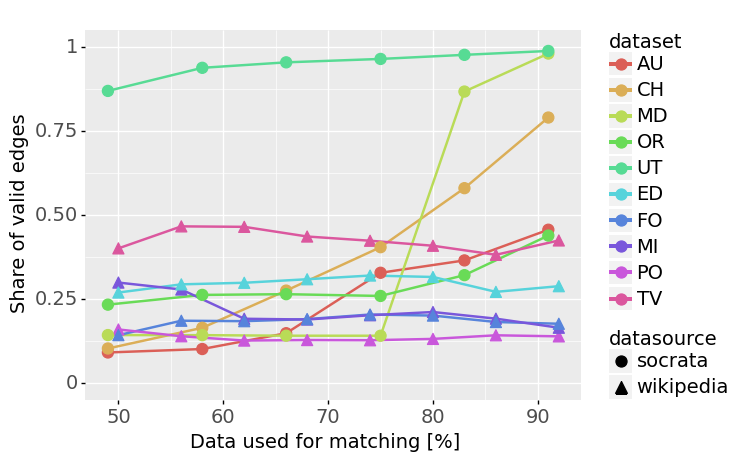

/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/validityOverMatchingTime_lol.jpg


In [4]:
dateToPercentageSocrata = {
    '2020-04-30' : 49,
    '2020-05-31' : 58,
    '2020-06-30' : 66,
    '2020-07-31' : 75,
    '2020-08-31' : 83,
    '2020-09-30' : 91
}
dateToPercentageWikipedia = {
'2011-05-07' : 50,
'2012-05-05' : 56,
'2013-05-04' : 62,
'2014-05-03' : 68,
'2015-05-02' : 74,
'2016-04-30' : 80,
'2017-04-29' : 86,
'2018-04-28' : 92, 
}

datasetToAbbreviation = {
'austintexas' : 'AU',
'chicago' : 'CH',
'gov.maryland' : 'MD',
'oregon' : 'OR',
'utah' : 'UT',
'education' : 'ED',
'football' : 'FO',
'military' : 'MI',
'politics' : 'PO',
'tv_and_film' : 'TV'
}

#TODO: map dates to percentages!
aggregateStatSocrataDF=aggregateStatSocrataDF[aggregateStatSocrataDF['trainEndDate'] != '2020-10-31']
aggregateStatSocrataDF["matchingTimePercentage"] = list(map(lambda x : dateToPercentageSocrata[x],list(aggregateStatSocrataDF['trainEndDate'])))
aggregateStatWikipediaDF["matchingTimePercentage"] = list(map(lambda x : dateToPercentageWikipedia[x],list(aggregateStatWikipediaDF['trainEndDate'])))
aggregateStatSocrataDF['datasource'] = "socrata"
aggregateStatWikipediaDF['datasource'] = "wikipedia"


totalAggregateDF = aggregateStatSocrataDF.append(aggregateStatWikipediaDF)
totalAggregateDF['dataset_long']=totalAggregateDF['dataset']
totalAggregateDF['dataset_unordered']= list(map(lambda x : datasetToAbbreviation[x],list(totalAggregateDF['dataset_long'])))

totalAggregateDF['dataset'] = pd.Categorical(totalAggregateDF['dataset_unordered'], ["AU","CH","MD","OR","UT","ED","FO","MI","PO","TV"])


def printAndSavePlots(df,datasource):
    plot = (ggplot(df, aes(x='matchingTimePercentage',ymin=0,ymax=1, y='validPercentageFullTimePeriodOfInteresting',group='dataset',color='dataset',shape="datasource", line='datasource')) 
      + geom_line(size=1.0) 
      + geom_point(size=4)
      + scale_x_continuous(name="Data used for matching [%]")
      + scale_y_continuous(name="Share of valid edges")
      + theme(text=element_text(size=14))
      #+ theme(axis_text_x=element_text(size=12),axis_text_y=element_text(size=12))
      + labs(title=''))
    print(plot)
    fname = 'exportedPlots/validityOverMatchingTime_' + datasource +'.jpg'
    plot.save(filename = fname)

printAndSavePlots(totalAggregateDF,"lol")


# Tuning

In [6]:
from random import random

#Only keep confirmed valid edges:
def filterDF(df):
    return df[((df['trainEndDate']=='2011-05-07') | (df['trainEndDate']=='2020-04-30')) & df['isInterstingStrict']]

allDfsFiltered = list(map(filterDF,allDfs))

def createScore(weights,dfFiltered):
    totalCount = np.where(dfFiltered['datasource']== 'wikipedia', 869, 364)
    scoreVector=((dfFiltered['strongPositive_scoreSum']/totalCount)*weights[0] + 
                        (dfFiltered['weakPositive_scoreSum']/totalCount)*weights[1] +
                        (dfFiltered['neutral_scoreSum']/totalCount)*weights[2] +
                        (dfFiltered['weakNegative_scoreSum']/totalCount)*weights[3] +
                        (dfFiltered['strongNegative_scoreSum']/totalCount)*weights[4])
    return scoreVector

def getRangeForThreshold(thresholds):
    ranges = []
    for i in range(len(thresholds)):
        if(i<len(thresholds)-1):
            ranges.append(thresholds[i+1]-thresholds[i])
        else:
            ranges.append(0)
    return np.array(ranges)

def appendF1DFEntry(dfForThisDsAndScore,rows_listF1,scoreName,y_pred,truthLabel,curWeights,curRatio):
    dsName=dfForThisDsAndScore['dataset'].iloc[0]
    #dfForThisDsAndScore = dfForThisDs[dfForThisDs[predScore].notnull()]
    y_test = dfForThisDsAndScore[truthLabel]
    precision, recall, thresholds = precision_recall_curve(y_test,y_pred)
    indices = (precision !=0) | (recall!=0)
    precision = precision[indices]
    recall = recall[indices]
    thresholds = thresholds[indices[0:len(indices)-1]]
    ranges = getRangeForThreshold(thresholds)
    f1_scores = 2*recall*precision/(recall+precision)
    f1_scores=f1_scores[0:len(f1_scores)-1]
    bestThresholdIndex=np.argmax(f1_scores)
    precision=precision[0:len(precision)-1]
    recall=recall[0:len(recall)-1]
    thisRange = ranges[bestThresholdIndex]
    maxRange = np.max(ranges)
    avgRange = np.mean(ranges)
    dict1 = {"dataset": dsName, 
             "scoreName": scoreName, 
             "bestThreshold": thresholds[bestThresholdIndex],
             "best_F1":f1_scores[bestThresholdIndex],#np.max(f1_scores),
             "precision":precision[bestThresholdIndex],
             "recall":recall[bestThresholdIndex],
             "strongPositiveWeight":curWeights[0],
             "weakPositiveWeight":curWeights[1],
             "neutralWeight":curWeights[2],
             "weakNegativeWeight":curWeights[3],
             "strongNegativeWeight":curWeights[4],
             "pr":curRatio['pr'],
             "nr":curRatio['nr'],
             "nTOp":curRatio['nTOp'],
             "ThresholdRange":thisRange,
             "ThresholdRangeMax":maxRange,
             "ThresholdRangeAvg":avgRange
            }
    rows_listF1.append(dict1)
    
ratiosToTest = [1.0,0.8,0.6,0.4,0.2,0.1,0.01,0.001,0.0001]
ratiosNegativeToPositive = [100.0,10.0,5.0,1.0,0.5,0.1,0.01]
scoreNames=[]
allWeights={}
allRatios={}

rows_listF1 = []
for curDF in allDfsFiltered:
    dsName=curDF['dataset'].iloc[0]
    print("Processing",dsName)
    for positiveRatio in ratiosToTest:
        for negativeRatio in ratiosToTest:
            for negativeToPositiveRatio in ratiosNegativeToPositive:
                if(negativeToPositiveRatio<=1):
                    weights = [1.0,positiveRatio*1.0,0,-negativeRatio*1.0*negativeToPositiveRatio,-1.0*negativeToPositiveRatio]
                    scoreName="score_pr:"+str(positiveRatio) + "_nr:" + str(negativeRatio) + "_nTOp:"+str(negativeToPositiveRatio)
                else:
                    positiveToNegativeRatio = 1/negativeToPositiveRatio
                    weights = [1.0*positiveToNegativeRatio,positiveToNegativeRatio*positiveRatio*1.0,0,-negativeRatio*1.0,-1.0]
                    scoreName="score_pr:"+str(positiveRatio) + "_nr:" + str(negativeRatio) + "_pTOn:"+str(positiveToNegativeRatio)
                allWeights[scoreName]=weights
                curRatio = {'pr':positiveRatio,'nr':negativeRatio,'nTOp':negativeToPositiveRatio}
                allRatios[scoreName]=curRatio
                scoreNames.append(scoreName)
                #print(weights)
                scoreVector = createScore(weights,curDF)
                #appendF1DFEntry(dfForThisDsAndScore,rows_listF1,scoreName,y_pred,truthLabel,curWeights,curRatio):
                appendF1DFEntry(curDF,rows_listF1,scoreName,scoreVector,'remainsValidFullTimeSpan',weights,curRatio)
                #With not all data: appendF1DFEntry(curDF,rows_listF1,scoreName,scoreVector,'remainsValidOneTimeUnitAfterTrain',weights,curRatio)

dfF1 = pd.DataFrame(rows_listF1)
dfF1.sort_values(by=['best_F1'],inplace=True)


Processing austintexas
Processing chicago
Processing gov.maryland
Processing oregon
Processing utah
Processing politics
Processing military
Processing football
Processing tv_and_film
Processing education


# Weight Transfer

In [9]:
def transferWeights(dsName,allDfs,printDetailed=False):
    if(printDetailed):
        print("-------------------------------------------------------------------------------------")
    print("Executing with ",dsName,"as the calibration dataset")
    if(printDetailed):
        print("-------------------------------------------------------------------------------------")
    otherDatasets = [ x for x in allDfs if x.iloc[0].dataset != dsName]
    dfF1ForThisDs = dfF1[dfF1['dataset']==dsName]
    best = dfF1ForThisDs.sort_values(by=['best_F1'],ascending=False).iloc[0]
    avgF1RetainedPercentages = 0.0
    for otherDataset in otherDatasets:
        otherDsName = otherDataset.iloc[0].dataset
        dfF1ForOtherDs = dfF1[dfF1['dataset']==otherDsName]
        bestOther = dfF1ForOtherDs.sort_values(by=['best_F1'],ascending=False).iloc[0]
        #print(bestOther.scoreName)
        #print(bestOther.bestThreshold)
        #print("-------------------------------------------------------------------------------------")
        #Now: Transfer weights and Threshold and see how good we are!
        transferredWeights = [best.strongPositiveWeight,best.weakPositiveWeight,best.neutralWeight,best.weakNegativeWeight,best.strongNegativeWeight]
        transferredThreshold = best.bestThreshold
        scoreVector = createScore(transferredWeights,otherDataset)
        y_pred = scoreVector > transferredThreshold
        y_test = otherDataset['remainsValidFullTimeSpan']
        transferredF1 = f1_score(y_test,y_pred)
        retainedF1Percentage = 100 * transferredF1 / bestOther.best_F1 
        avgF1RetainedPercentages = avgF1RetainedPercentages + retainedF1Percentage
        if(printDetailed):
            print("-------------------------------------------------------------------------------------")
            print(otherDsName)
            print("Best F1",bestOther.best_F1)
            print("Transferred F1",transferredF1)
            print("F1 retained [%]: ",retainedF1Percentage,"%")
        #print("-------------------------------------------------------------------------------------")
    print('avgF1RetainedPercentages',avgF1RetainedPercentages/len(otherDatasets))

def transferWeightsBetween(fromDs,toDs,printDetailed=False):
    #transfer from:
    fromDsName = fromDs.iloc[0].dataset
    dfF1ForThisDs = dfF1[dfF1['dataset']==fromDsName]
    best = dfF1ForThisDs.sort_values(by=['best_F1'],ascending=False).iloc[0]
    #transfer to:
    otherDsName = toDs.iloc[0].dataset
    dfF1ForOtherDs = dfF1[dfF1['dataset']==otherDsName]
    bestOther = dfF1ForOtherDs.sort_values(by=['best_F1'],ascending=False).iloc[0]
    #print(bestOther.scoreName)
    #print(bestOther.bestThreshold)
    #print("-------------------------------------------------------------------------------------")
    #Now: Transfer weights and Threshold and see how good we are!
    transferredWeights = [best.strongPositiveWeight,best.weakPositiveWeight,best.neutralWeight,best.weakNegativeWeight,best.strongNegativeWeight]
    transferredThreshold = best.bestThreshold
    scoreVector = createScore(transferredWeights,toDs)
    y_pred = scoreVector > transferredThreshold
    y_test = toDs['remainsValidFullTimeSpan']
    transferredF1 = f1_score(y_test,y_pred)
    transferredPrecision = precision_score(y_test,y_pred)
    transferredRecall = recall_score(y_test,y_pred)
    retainedF1Percentage = 100 * transferredF1 / bestOther.best_F1 
    if(fromDsName == 'football' or fromDsName == 'chicago'):
        print("-------------------------------------------------------------------------------------")
        print(fromDsName," To:",otherDsName)
        print("Best F1",bestOther.best_F1)
        print("Transferred F1",transferredF1)
        print("Transferred Precision",transferredPrecision)
        print("Transferred Recall",transferredRecall)
        print("F1 retained [%]: ",retainedF1Percentage,"%")
    return retainedF1Percentage
    
def runForList(dsList):
    print("-------------------------------------------------------------------------------------")
    print(dsList[0].iloc[0].datasource)
    print("-------------------------------------------------------------------------------------")
    print(','.join(map(lambda x: str(x.iloc[0].dataset),dsList)))
    for ds in dsList:
        dsName = ds.iloc[0].dataset
        print(dsName,end='')
        for otherDs in dsList:
            print(",",end='')
            otherDsName = otherDs.iloc[0].dataset
            if(otherDsName==dsName):
                print("-",end='')
            else:
                print(round(transferWeightsBetween(ds,otherDs),2),end='')
        print("\n")
        
allDfsWikipedia = list(filter(lambda x: x.iloc[0].datasource == 'wikipedia', allDfsFiltered))
allDfsSocrata = list(filter(lambda x: x.iloc[0].datasource == 'socrata', allDfsFiltered))

runForList(allDfsWikipedia)
runForList(allDfsSocrata)

#print best weight settings:
datasetNames = dfF1['dataset'].unique()
print(datasetNames)
bestSocrata="chicago"
dfF1ForThisDs = dfF1[dfF1['dataset']==bestSocrata]
best = dfF1ForThisDs.sort_values(by=['best_F1'],ascending=False).iloc[0]
print("bestSocrata")
print(best)

bestWikipedia="football"
dfF1ForThisDs = dfF1[dfF1['dataset']==bestWikipedia]
best = dfF1ForThisDs.sort_values(by=['best_F1'],ascending=False).iloc[0]
print("bestWikipedia:")
print(best)



#transferWeights('chicago',allDfsSocrata)

#print(withoutOther)
#print(best)


    
#Wikipedia:
#for dsName in wikipediaNames:
#    withoutOther = [ x for x in wikipediaNames if x != dsName]
#    dfF1ForThisDs = dfF1[dfF1['dataset']==dsName]
#    best = dfF1.sort_values(by=['best_F1'],inplace=True,ascending=False).iloc[0]


-------------------------------------------------------------------------------------
wikipedia
-------------------------------------------------------------------------------------
politics,military,football,tv_and_film,education
politics,-,72.03,83.99,83.31,87.54

military,84.27,-,97.95,99.94,98.44

football,-------------------------------------------------------------------------------------
football  To: politics
Best F1 0.3436178478845347
Transferred F1 0.3045264412792171
Transferred Precision 0.18272269577787748
Transferred Recall 0.9134085868779747
F1 retained [%]:  88.62358086287374 %
88.62,-------------------------------------------------------------------------------------
football  To: military
Best F1 0.4763929654381281
Transferred F1 0.46485685019992495
Transferred Precision 0.3335284730943186
Transferred Recall 0.76678002894356
F1 retained [%]:  97.57844551134511 %
97.58,-,-------------------------------------------------------------------------------------
football  To: 

# Json Export Of Weight Settings

In [66]:
#print best weight settings:
datasetNames = dfF1['dataset'].unique()
print(datasetNames)
for dsName in datasetNames:
    dfF1ForThisDs = dfF1[dfF1['dataset']==dsName]
    best = dfF1ForThisDs.sort_values(by=['best_F1'],ascending=False).iloc[0]
    print("-------------------------------------------------------------------------")
    print(dsName)
    print("{")
    print("\"alpha\" : ",best.bestThreshold,",")
    print("\"strongPositiveWeight\" : ",best.strongPositiveWeight,",")
    print("\"weakPositiveWeight\" : ",best.weakPositiveWeight,",")
    print("\"neutralWeight\" : ",best.neutralWeight,",")
    print("\"weakNegativeWeight\" : ",best.weakNegativeWeight,",")
    print("\"strongNegativeWeight\" : ",best.strongNegativeWeight,",")
    print("\"eventCountInLineage\" : 869")
    print("}")

['gov.maryland' 'football' 'politics' 'oregon' 'education' 'chicago'
 'austintexas' 'military' 'tv_and_film' 'utah']
-------------------------------------------------------------------------
gov.maryland
{
"alpha" :  -0.32142554702175824 ,
"strongPositiveWeight" :  0.2 ,
"weakPositiveWeight" :  0.04000000000000001 ,
"neutralWeight" :  0 ,
"weakNegativeWeight" :  -1.0 ,
"strongNegativeWeight" :  -1.0 ,
"eventCountInLineage" : 869
}
-------------------------------------------------------------------------
football
{
"alpha" :  -0.0005176738880368239 ,
"strongPositiveWeight" :  1.0 ,
"weakPositiveWeight" :  0.8 ,
"neutralWeight" :  0 ,
"weakNegativeWeight" :  -1.0000000000000002e-06 ,
"strongNegativeWeight" :  -0.01 ,
"eventCountInLineage" : 869
}
-------------------------------------------------------------------------
politics
{
"alpha" :  -0.00032214746050632915 ,
"strongPositiveWeight" :  1.0 ,
"weakPositiveWeight" :  0.1 ,
"neutralWeight" :  0 ,
"weakNegativeWeight" :  -1.00000000000

# Tuning Plots (Boxplot + Scatterplot)

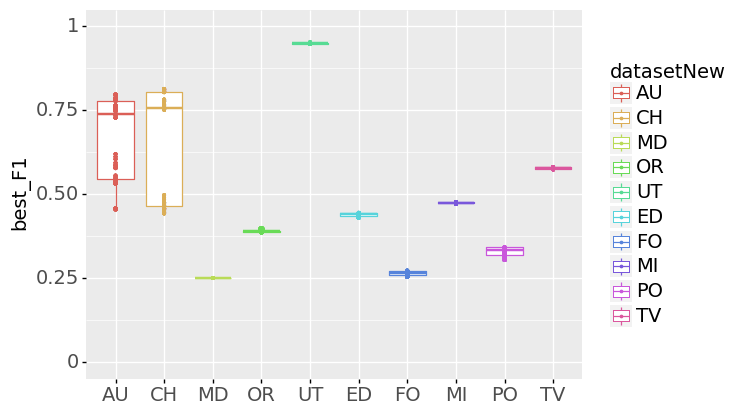

/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/bestTunedF1both.jpg


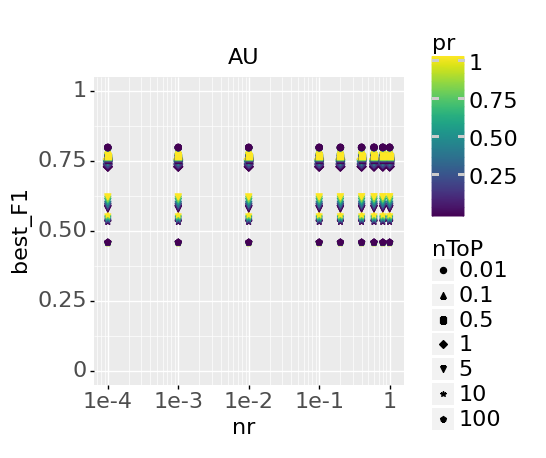

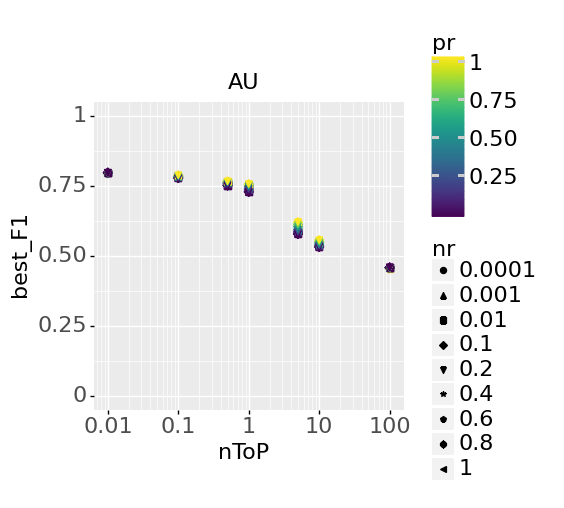

/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/tuningResult_nr_AU.jpg
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/tuningResult_nToP_AU.jpg


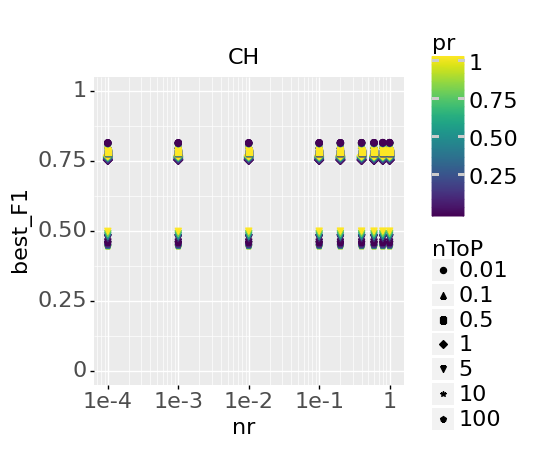

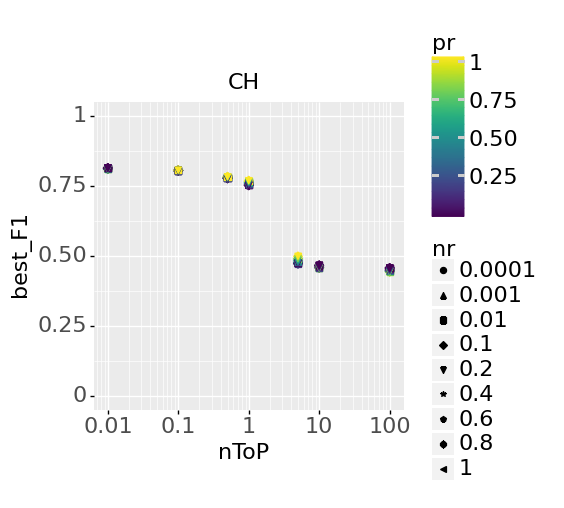

/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/tuningResult_nr_CH.jpg
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/tuningResult_nToP_CH.jpg


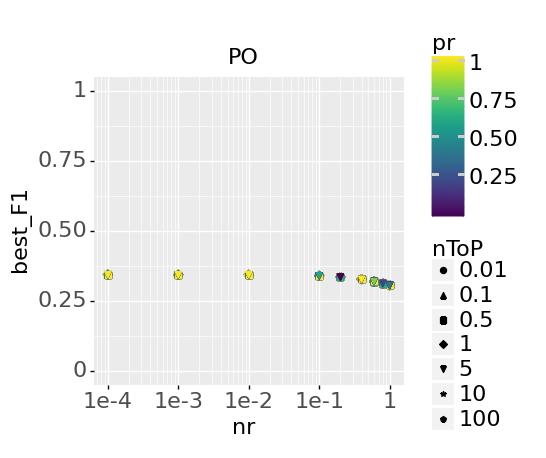

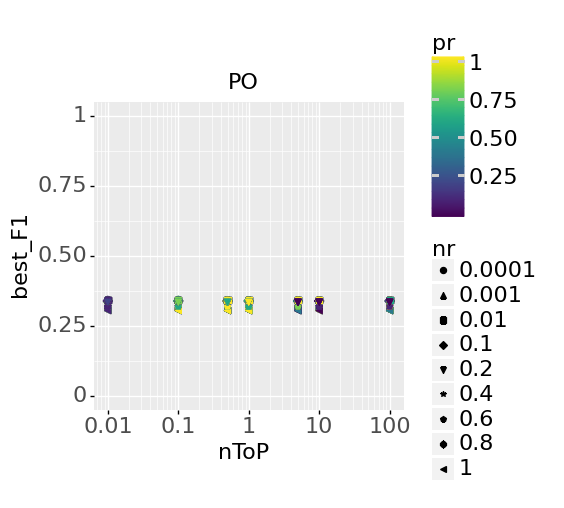

/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/tuningResult_nr_PO.jpg
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/tuningResult_nToP_PO.jpg


In [48]:
# Define ratios:
dfF1['weakToStrongNegativeWeightRelation']=dfF1['weakNegativeWeight']/dfF1['strongNegativeWeight']
dfF1['weakToStrongPositiveWeightRelation']=dfF1['weakPositiveWeight']/dfF1['strongPositiveWeight']
dfF1['weakToWeakWeightRelation']=dfF1['weakPositiveWeight']/(-dfF1['weakNegativeWeight'])
dfF1['strongToStrongWeightRelation']=dfF1['strongPositiveWeight']/(-dfF1['strongNegativeWeight'])
dfF1['nTOpAsData']=dfF1['nTOp']
dfF1['nrAsData']=dfF1['nr']
dfF1['nToP']=dfF1['nTOpAsData'].astype('category')
dfF1['nr']=dfF1['nrAsData'].astype('category')

#Some preprocessing to make the plots look nicer:
dfF1Wikipedia = dfF1[dfF1['dataset'].isin(['politics', 'military', 'football', 'tv_and_film', 'education'])]
dfF1Socrata = dfF1[dfF1['dataset'].isin(['utah', 'chicago', 'austintexas', 'oregon', 'gov.maryland'])]
datasetToAbbreviation = {
'austintexas' : 'AU',
'chicago' : 'CH',
'gov.maryland' : 'MD',
'oregon' : 'OR',
'utah' : 'UT',
'education' : 'ED',
'football' : 'FO',
'military' : 'MI',
'politics' : 'PO',
'tv_and_film' : 'TV'
}

aggregateStatSocrataDF['datasource'] = "socrata"
aggregateStatWikipediaDF['datasource'] = "wikipedia"

dfF1['dataset_long']=dfF1['dataset']
dfF1['dataset_unordered']= list(map(lambda x : datasetToAbbreviation[x],list(dfF1['dataset_long'])))
dfF1['dataset'] = pd.Categorical(dfF1['dataset_unordered'], ["AU","CH","MD","OR","UT","ED","FO","MI","PO","TV"])

# The actual plotting function for boxplots:
def printBoxplot(df,datasource):
    p = (ggplot(df,aes(ymin=0,ymax=1,x='datasetNew',y='best_F1',color='datasetNew'))
    + geom_boxplot()
    + geom_point(size=0.5)
    + theme(text=element_text(size=14))#,axis_text_x=element_text(rotation=45, hjust=1))
    + labs(x="")
    )
    print(p)
    fname = 'exportedPlots/bestTunedF1' + datasource +'.jpg'
    p.save(filename = fname)

printBoxplot(dfF1,"both")

scatterPlotWidth=4
scatterPlotHeight=4
textSizeScatterPlot=16

datasetNames=dfF1['dataset'].unique()
#plot the three datasets that are interesting:
for dsName in ['AU','CH','PO']:
    curDF = dfF1[dfF1['dataset']==dsName]
    nrPlot = ggplot(curDF, aes(x='nrAsData',ymin=0,ymax=1, y='best_F1',color='pr',shape='nToP')) + scale_x_log10() + geom_point(size=2)  + labs(title = dsName,x="nr") + theme(text=element_text(size=textSizeScatterPlot)) + theme(figure_size = (scatterPlotWidth, scatterPlotHeight))
    nTOpPlot = ggplot(curDF, aes(x='nTOpAsData',ymin=0,ymax=1, y='best_F1',color='pr',shape='nr')) + scale_x_log10() + geom_point(size=2)  + labs(title= dsName,x="nToP") + theme(text=element_text(size=textSizeScatterPlot)) + theme(figure_size = (scatterPlotWidth, scatterPlotHeight))
    print(nrPlot)
    print(nTOpPlot)
    fname = 'exportedPlots/tuningResult_nr_' + dsName +'.jpg'
    nrPlot.save(filename = fname)
    fname = 'exportedPlots/tuningResult_nToP_' + dsName +'.jpg'
    nTOpPlot.save(filename = fname)